<a href="https://colab.research.google.com/github/Megancodes2017/Megancodes2017/blob/main/Dodgers_vs_Robert_Suarez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pybaseball
import pandas as pd
from pybaseball import playerid_lookup, statcast_pitcher, statcast_batter
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.6/432.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 48.6 MB/s eta 0:00:00


In [4]:
pid_df = playerid_lookup('Suarez', 'Robert')
print(pid_df[['name_last', 'name_first', 'key_mlbam']])

  name_last name_first  key_mlbam
0    suarez     robert     663158


In [5]:
pid = pid_df['key_mlbam'].iloc[0]

In [6]:
# Get Suarez pitch data 2025
start_date = '2025-03-20'
end_date = '2025-09-01'
pitches = statcast_pitcher(start_date, end_date, pid)

Gathering Player Data


In [7]:
# Filter to PA where LAD is batting
if 'bat_team' in pitches.columns:
  dodgers_pitches = pitches[pitches['bat_team'] == 'LAD'].copy()
else:
  dodgers_pitches = pitches[(pitches['home_team'] == 'LAD') | (pitches['away_team'] == 'LAD')].copy()

In [9]:
print(f'Total pitches thrown 2025 by Suarez: {len(pitches):,}')
print(f'Pitches vs Dodgers: {len(dodgers_pitches):,}')

Total pitches thrown 2025 by Suarez: 920
Pitches vs Dodgers: 60


In [10]:
if 'pitch_name' not in dodgers_pitches.columns and 'pitch_type' in dodgers_pitches.columns:
  code2name = {
      'FF': 'four-seam', 'CH': 'changeup', 'Sinker': 'SI'
  }
  dodgers_pitches['pitch_name'] = dodgers_pitches['pitch_type'].map(code2name).fillna(dodgers_pitches['pitch_type'])

In [11]:
# Create outcome columns for simple metrics
def outcome_to_bases(ev):
  if pd.isna(ev):
    return 0
  ev = ev.lower()
  if 'single' in ev:
    return 1
  if 'double' in ev:
    return 2
  if 'triple' in ev:
    return 3
  if 'home_run' in ev or 'home run' in ev:
    return 4
  return 0

dodgers_pitches['bases'] = dodgers_pitches['events'].apply(outcome_to_bases)
dodgers_pitches['is_pa'] = dodgers_pitches['events'].notna() | dodgers_pitches['description'].isin(['hit_into_play', 'field_out', 'hit_by_pitch'])

In [12]:
# Aggregate per pitch type
group = dodgers_pitches.groupby('pitch_name').agg(
    pitches = ('pitch_name', 'size'),
    PA = ('is_pa', 'sum'),
    hits = ('events', lambda s: s.str.contains('single|double|triple|home_run', case=False, na=False).sum()),
    total_bases = ('bases', 'sum'),
    walks = ('events', lambda s: s.str.contains('walk', case=False, na=False).sum()),
    strikeouts = ('events', lambda s: s.str.contains('strikeout', case=False, na=False).sum()),
    avg_ev = ('launch_angle', 'mean'),
    hard_hit_pct = ('launch_speed', lambda s: (s>=95).sum()/s.count() if s.count()>0 else pd.NA),
    whiff_rate = ('description', lambda s: (s == 'swinging_strike').sum() if s.count()>0 else pd.NA)
).reset_index()

In [13]:
# Add computed stats
group['AVG'] = group['hits'] / group['PA']
group['SLG'] = group['total_bases'] / group['PA']
group['OBP'] = (group['hits'] + group['walks'] + group['strikeouts']) / (group['PA'] + group['walks'] + group['strikeouts'] + group['hits'])
group['ISO'] = group['SLG'] - group['AVG']
group = group.sort_values('PA', ascending=False)
print(group[['pitch_name', 'pitches', 'PA', 'AVG', 'OBP', 'SLG', 'ISO', 'avg_ev', 'hard_hit_pct', 'whiff_rate']])

        pitch_name  pitches  PA       AVG       OBP       SLG       ISO  \
0  4-Seam Fastball       27   7  0.285714  0.363636  0.714286  0.428571   
1         Changeup       18   5  0.600000  0.444444  1.200000  0.600000   
2           Sinker       15   5  0.000000  0.285714  0.000000  0.000000   

      avg_ev  hard_hit_pct  whiff_rate  
0  35.600000      0.300000           1  
1  17.000000      0.333333           2  
2  36.428571      0.285714           1  


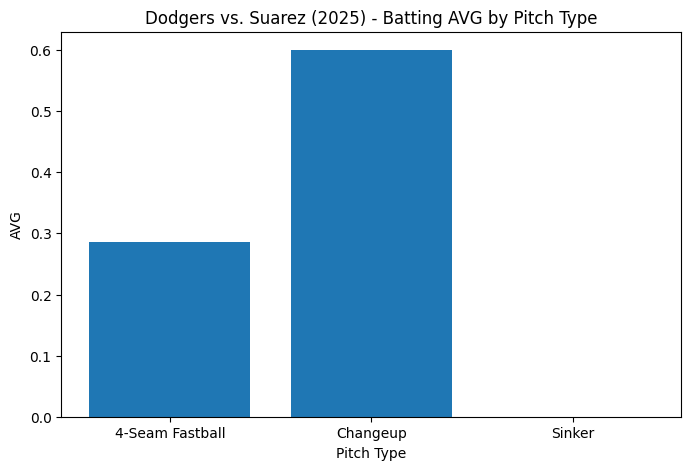

In [14]:
# Plot AVG by pitch type
plt.figure(figsize=(8, 5))
plt.bar(group['pitch_name'], group['AVG'])
plt.title('Dodgers vs. Suarez (2025) - Batting AVG by Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('AVG')
plt.show()

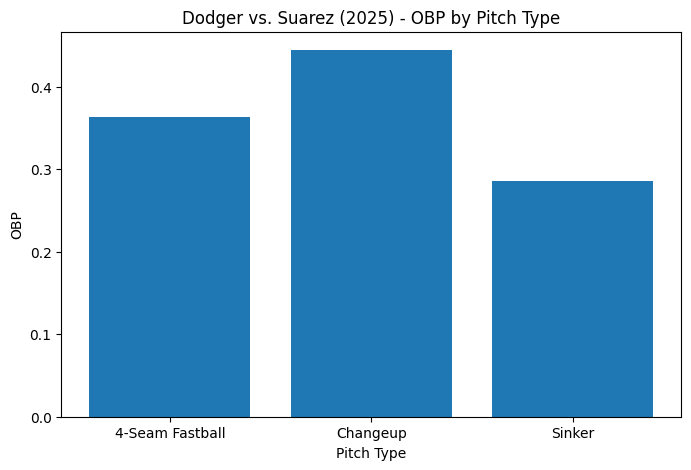

In [15]:
# Plot by OBP
plt.figure(figsize=(8, 5))
plt.bar(group['pitch_name'], group['OBP'])
plt.title('Dodger vs. Suarez (2025) - OBP by Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('OBP')
plt.show()

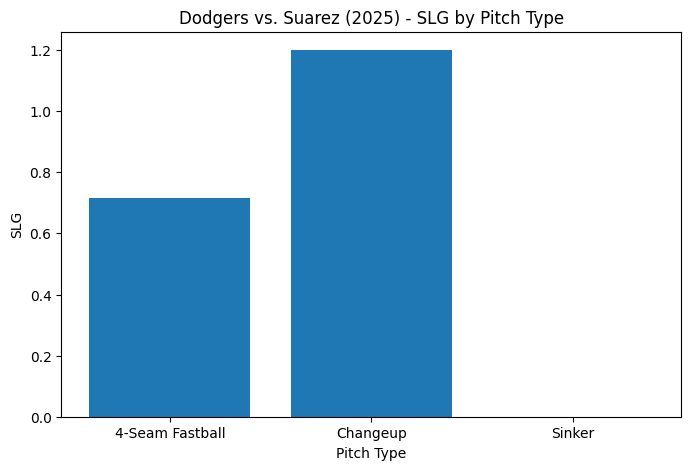

In [16]:
# Plot by SLG
plt.figure(figsize=(8, 5))
plt.bar(group['pitch_name'], group['SLG'])
plt.title('Dodgers vs. Suarez (2025) - SLG by Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('SLG')
plt.show()